# Experiment 1

The experiment was conducted as a series to determine depth accuracy.

```text
Wall+box   500
|-----------|

Wall+box               1000
|-----------|-----------|
Wall       box         1000    
|-----------|-----------|


Wall+box                           1500
|-----------|-----------|-----------|
Wall       box                     1500    
|-----------|-----------|-----------|
Wall                   box         1500    
|-----------|-----------|-----------|
```

In [76]:
import os
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (20,6)

## Samples

In [77]:
class CoordSample:
    coordx: int
    coordy: int
    expected: float
    observed: float

    def __init__(self, coordx: int, coordy: int, expected: float):
        self.coordx = coordx
        self.coordy = coordy
        self.expected = expected
        self.observed = 0

    def __repr__(self) -> str:
        return 'coord: {}, {} expected: {:6.3f} observed: {:20.18f} deviation: {:2.5f}'.format(self.coordx, self.coordy, self.expected, self.observed,  self.observed - self.expected)

    def sample_data(self, depth_data):
        self.observed = depth_data[self.coordy, self.coordx]


class Sample:
    box: CoordSample
    a4: CoordSample

    def __init__(self, box: CoordSample, a4: CoordSample):
        self.box = box
        self.a4 = a4

    def __repr__(self) -> str:
        return f'\tbox: {self.box}\n\ta4 : {self.a4}'

    def sample_data(self, data):
        self.box.sample_data(data)
        self.a4.sample_data(data)


class Samples:
    samples: dict[str, Sample]

    def __init__(self, samples: dict[str, Sample]):
        self.samples = samples

    def __repr__(self) -> str:
        s = ''
        for key in self.samples:
            sample = self.samples[key]
            s += f'Sample {key}:\n{sample}\n'
        return s

In [78]:
# data = {
#     'basePath': './depth_calibration',
#     '500': {
#         'dir': 'd500mm',
#         'offset': 0.5, # camera offset from wall in meters
#         'observations': {
#             '0': {
#                 'filename': ''
#             }
#         }
#     }
# }


class Observation:
    filename: str
    box_depth_offset: float
    camera_offset: float

    def __init__(self, filename: str, camera_offset: float, box_position: int):
        self.filename = filename
        self.camera_offset = camera_offset
        self.box_depth_offset = box_depth_offset(box_position)

    def __repr__(self) -> str:
        return f'<Observation wall box: {self.box_depth_offset} camera: {self.camera_offset} uuid: {self.filename}>'


class Experiment:
    dirname: str
    offset: float
    observations: dict[str, Observation]
    samples: Samples
    data: any
        
    def __init__(self, dirname: str):
        self.dirname = f'd{dirname}mm'
        self.offset = float(dirname)/1000
        self.observations = dict()
        self.samples = None
        self.data = None
        
    def __repr__(self) -> str:
        s = f'<Experiment {self.dirname}>\n'
        for key in self.observations:
            s += f'\t{self.observations[key].__repr__()}\n'
        return s
    
    def read_depth_data(self, obs_number: str): 
        """
        read the depth data for the observation number provided.
        """
        obs = self.observations.get(obs_number)
        if obs == None:
            print(f'No observation at position: {obs_number}')
            return
        
        filename = obs.filename
        with open(f"{os.path.join(os.getcwd(), './depth_calibration', self.dirname, filename)}.json") as in_file:
            json_content = json.loads(in_file.read())
        # self.data = np.array(json_content['depth_data']).astype('float32')
        return np.array(json_content['depth_data']).astype('float32')

    def dataframe(self):
        """
        Generates a dataframe based on each sample provided.
        :return:
        """

    
    def plot(self):
        if self.samples == None:
            print("Specify samples")
            return

        obs_len = len(self.observations)
        samples = self.samples.samples
        samples_len = len(samples)
        # set the matplot lib figure size
        plt.rcParams["figure.figsize"] = (20, obs_len * 4.5)

        # plots two columns, with dynamic number of rows depending on the number of samples.
        fig, axs = plt.subplots(math.ceil(obs_len/2), 2)
        fig.suptitle('Horizontally stacked subplots')
        for i in range(obs_len):
            index = str(i)

            data = self.read_depth_data(index)
            sample = samples.get(index)

            if obs_len > 2:
                # if a matrix of plots
                ax = axs[math.floor(i/2), i % 2]
            else:
                # if a single row of plots
                ax = axs[i]

            pcm = ax.pcolormesh(data)

            if sample:
                sample.sample_data(data)
                ax.scatter(sample.box.coordx, sample.box.coordy, 100, c="red")
                ax.scatter(sample.a4.coordx, sample.a4.coordy, 100, c="red")

            fig.colorbar(pcm, ax=ax)    

        print(self.samples)

    
def box_depth_offset(position: int) -> float:
    """
    box_depth_offset returns the offset of how much closer the
    front of the box is to the camera relative to the wall.
    """
    if position == 0:
        return 0.23
    return float(position) * 0.5


# Setup Experiments

In [79]:
e500 = Experiment(dirname='500')
e500.observations['0'] = Observation('74D495C1-0C9E-433C-A2A4-871F450E1A91', 0.5, 0)
e500.observations['1'] = Observation('CA6000DB-526F-4F96-8522-6891EAEB2F58', 0.5, 0)

e1000 = Experiment(dirname='1000')
e1000.observations['0'] = Observation('A69483E9-FD29-4475-9A17-564ACC5F6BC0', 1, 0)
e1000.observations['1'] = Observation('53BA22A4-EBCB-443F-8DC9-6EE200910287', 1, 1)

e1500 = Experiment(dirname='1500')
e1500.observations['0'] = Observation('C92188FC-ED3D-4ADA-8CDD-0D3D26AB4E8F', 1.5, 0)
e1500.observations['1'] = Observation('BA45BDCD-B7CB-417C-BEFF-6327EA545B7E', 1.5, 1)
e1500.observations['2'] = Observation('DFC3F4F8-4745-4E60-8D22-14763248F13C', 1.5, 2)

e2000 = Experiment(dirname='2000')
e2000.observations['0'] = Observation('44FBF366-E2C0-4C86-B8B9-FDB5F89ED9F0', 2, 0)
e2000.observations['1'] = Observation('C271A2C7-6FEB-4BD3-A944-7DAE2FD0702E', 2, 1)
e2000.observations['2'] = Observation('25DBD080-1E8D-4620-81C9-680CF9AD1FAA', 2, 2)
e2000.observations['3'] = Observation('ED7A9BA9-77E2-4C9A-848B-45E611D8660A', 2, 3)

e2500 = Experiment(dirname='2500')
e2500.observations['0'] = Observation('8FB25589-911A-4105-B39A-EFDC1A246020', 3, 0)
e2500.observations['1'] = Observation('FEDC109A-AA1F-4571-A176-D34712B23B06', 3, 1)
e2500.observations['2'] = Observation('4E2FC32C-5B00-40B4-B62D-21F83E23B765', 3, 2)
e2500.observations['3'] = Observation('CEBEDC2A-13BD-4046-ACFD-5F328858FAF7', 3, 3)
e2500.observations['4'] = Observation('7C74CC14-9CC5-498D-993E-E689EB4D255D', 3, 4)

In [59]:
# fig, axs = plt.subplots(1, 2)
# fig.suptitle('Horizontally stacked subplots')
# for col in range(2):
#     index = str(col)
#     data = e1000.read_depth_data(index)
#     sample = samples.samples[index]

#     ax = axs[col]
#     pcm = ax.pcolormesh(data)

#     if sample:
#         sample.sample_data(data)
#         ax.scatter(sample.box.coordx, sample.box.coordy, 100, c="red")
#         ax.scatter(sample.a4.coordx, sample.a4.coordy, 100, c="red")

#     fig.colorbar(pcm, ax=ax)

# print(samples)

figs: 1 2
Sample 0:
	box: coord: 400, 400 expected:  0.770 observed: 0.787086844444274902
	a4 : coord: 400, 300 expected:  1.000 observed: 0.998050689697265625
Sample 1:
	box: coord: 400, 450 expected:  0.500 observed: 0.553214073181152344
	a4 : coord: 400, 300 expected:  1.000 observed: 0.999023437500000000



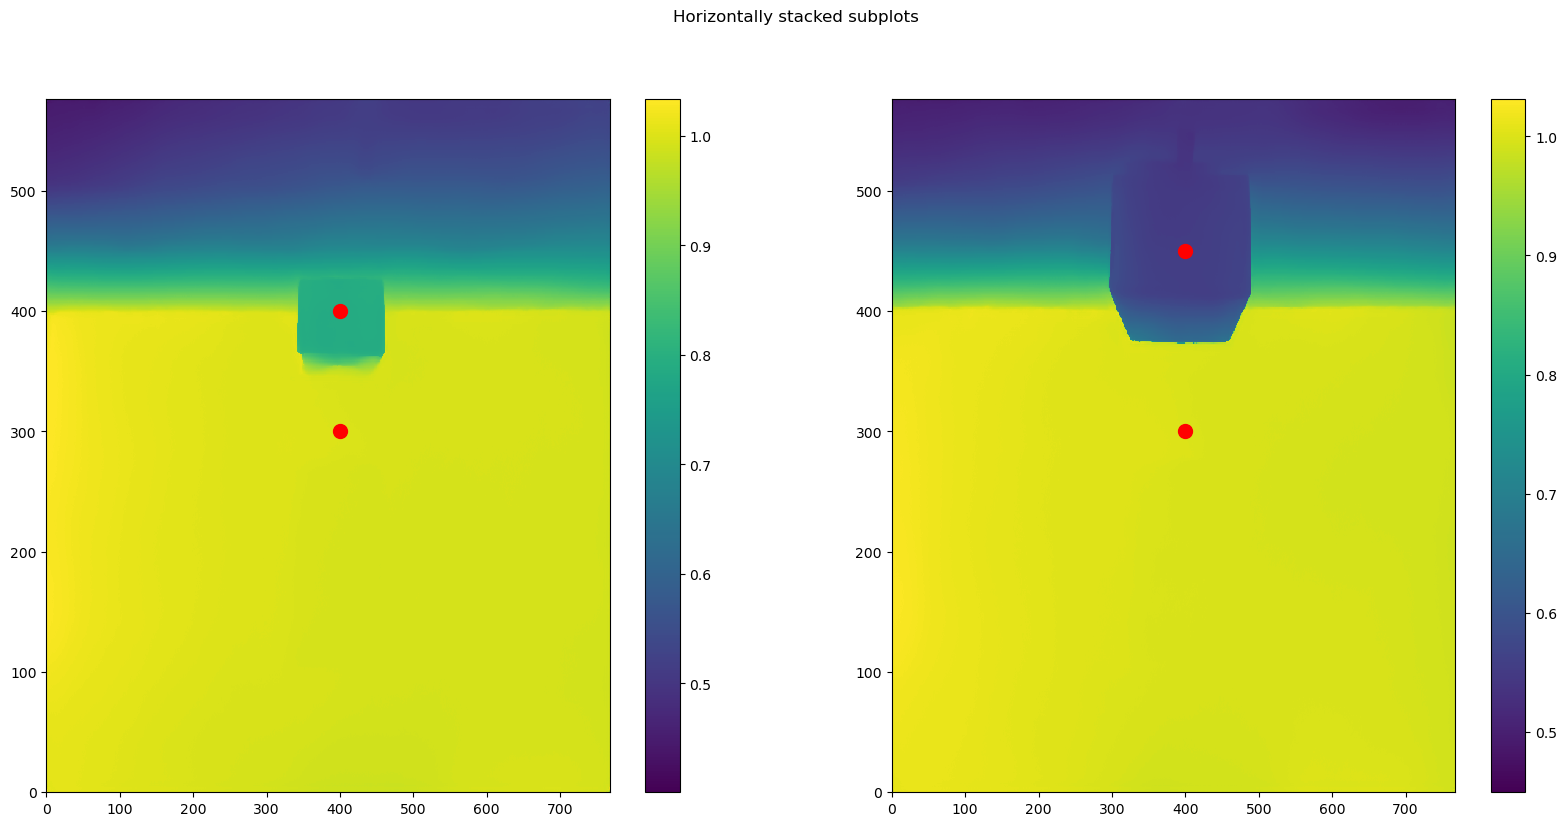

In [62]:
e1000.samples = Samples({
    '0': Sample(box=CoordSample(400, 400, 0.77), a4=CoordSample(400, 300, 1)),
    '1': Sample(box=CoordSample(400, 450, 0.5), a4=CoordSample(400, 300, 1))
})

e1000.plot()

figs: 2 2
0 0 AxesSubplot(0.125,0.53;0.352273x0.35)
0 1 AxesSubplot(0.547727,0.53;0.352273x0.35)
1 0 AxesSubplot(0.125,0.11;0.352273x0.35)
Sample 0:
	box: coord: 390, 360 expected:  1.270 observed: 1.301143527030944824
	a4 : coord: 400, 300 expected:  1.500 observed: 1.504775404930114746
Sample 1:
	box: coord: 400, 380 expected:  1.000 observed: 0.992244005203247070
	a4 : coord: 400, 300 expected:  1.500 observed: 1.504775404930114746
Sample 2:
	box: coord: 400, 450 expected:  0.500 observed: 0.579183578491210938
	a4 : coord: 400, 300 expected:  1.500 observed: 1.506989955902099609



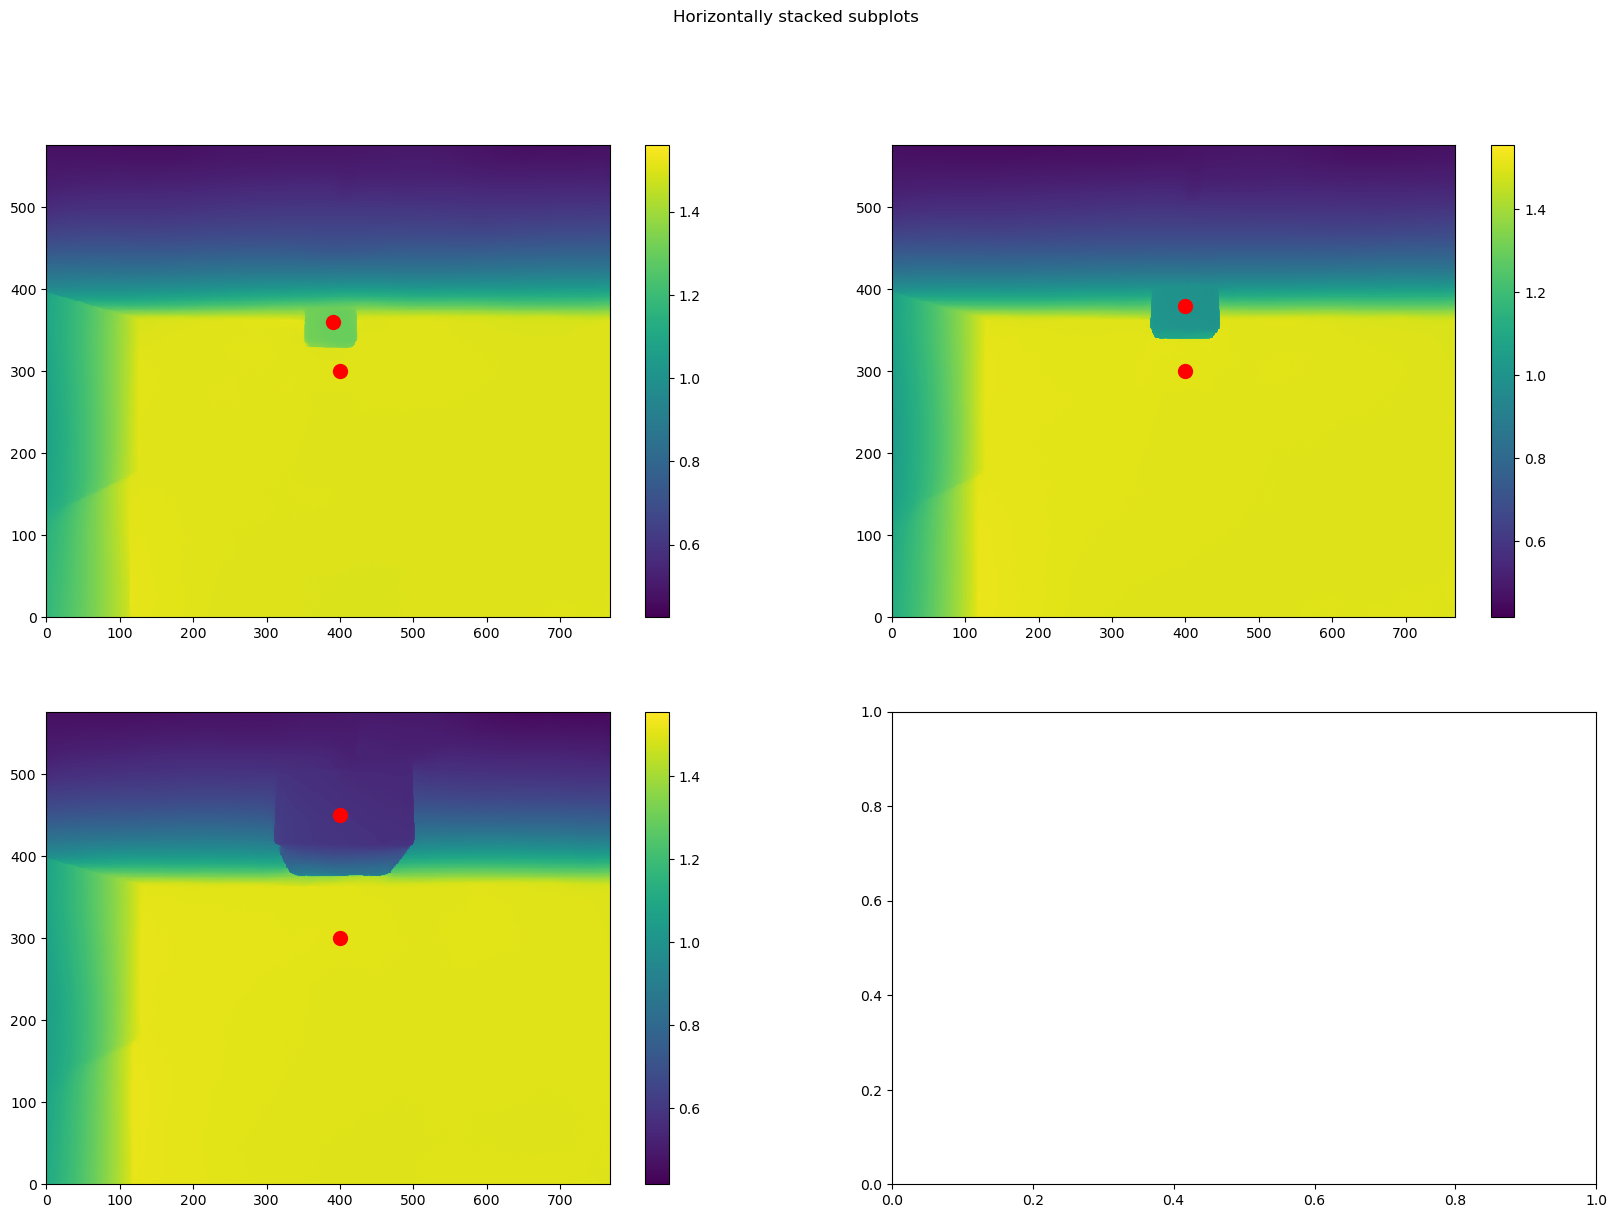

In [63]:
e1500.samples = Samples({
    '0': Sample(box=CoordSample(390, 360, 1.27), a4=CoordSample(400, 300, 1.5)),
    '1': Sample(box=CoordSample(400, 380, 1), a4=CoordSample(400, 300, 1.5)),
    '2': Sample(box=CoordSample(400, 450, 0.5), a4=CoordSample(400, 300, 1.5)),
})

e1500.plot()

figs: 2 2
0 0 AxesSubplot(0.125,0.53;0.352273x0.35)
0 1 AxesSubplot(0.547727,0.53;0.352273x0.35)
1 0 AxesSubplot(0.125,0.11;0.352273x0.35)
1 1 AxesSubplot(0.547727,0.11;0.352273x0.35)
Sample 0:
	box: coord: 380, 340 expected:  1.770 observed: 1.805995464324951172
	a4 : coord: 390, 300 expected:  2.000 observed: 2.011780023574829102
Sample 1:
	box: coord: 390, 345 expected:  1.500 observed: 1.601250886917114258
	a4 : coord: 400, 300 expected:  2.000 observed: 2.007843017578125000
Sample 2:
	box: coord: 400, 375 expected:  1.000 observed: 0.987462520599365234
	a4 : coord: 400, 300 expected:  2.000 observed: 2.005874633789062500
Sample 3:
	box: coord: 400, 450 expected:  0.500 observed: 0.516128540039062500
	a4 : coord: 400, 300 expected:  2.000 observed: 2.005874633789062500



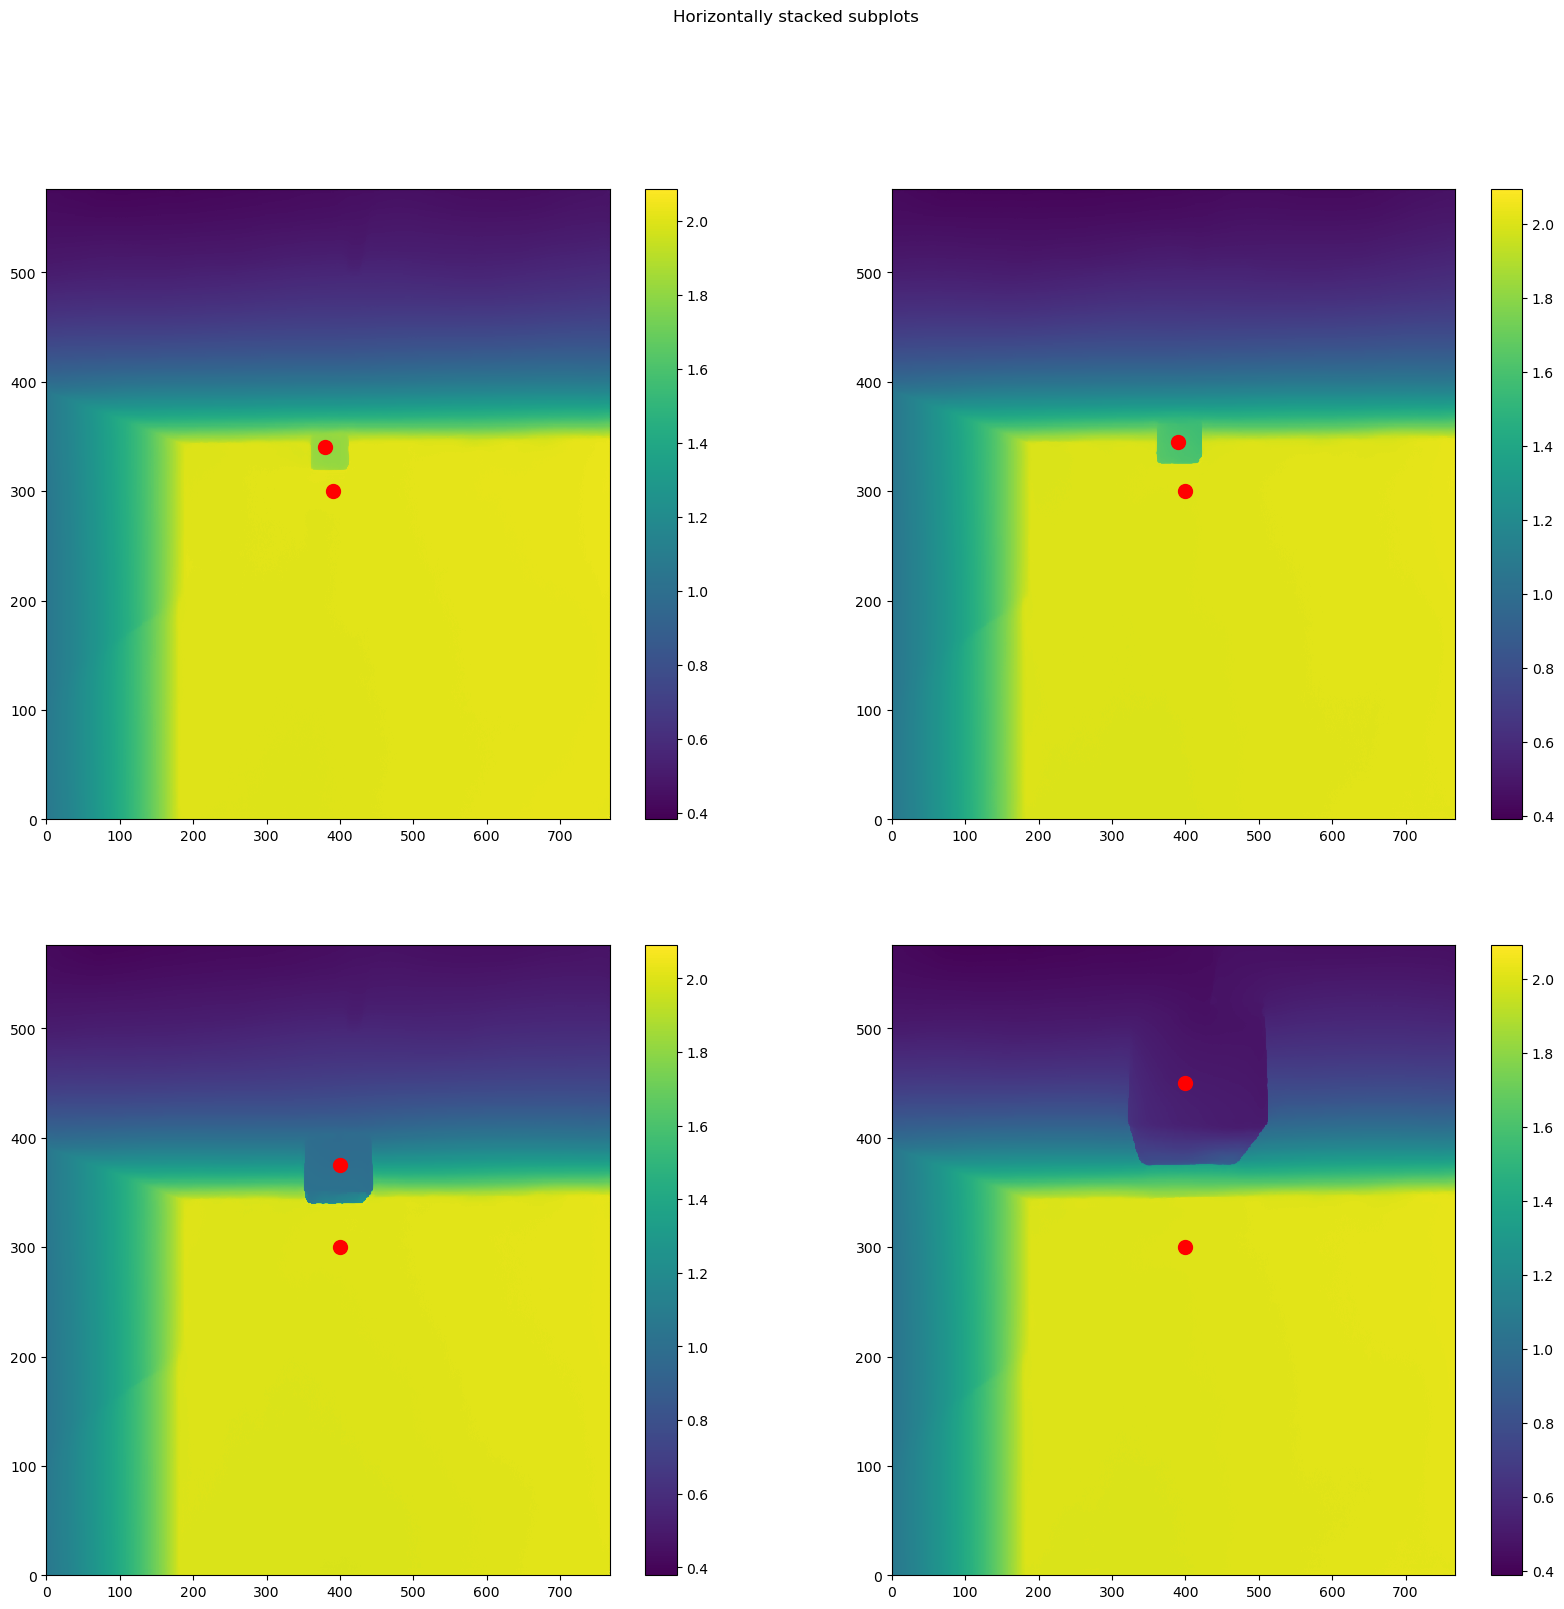

In [64]:
e2000.samples = Samples({
    '0': Sample(box=CoordSample(380, 340, 1.77), a4=CoordSample(390, 300, 2)),
    '1': Sample(box=CoordSample(390, 345, 1.5), a4=CoordSample(400, 300, 2)),
    '2': Sample(box=CoordSample(400, 375, 1), a4=CoordSample(400, 300, 2)),
    '3': Sample(box=CoordSample(400, 450, 0.5), a4=CoordSample(400, 300, 2))
})

e2000.plot()

figs: 3 2
Sample 0:
	box: coord: 390, 335 expected:  2.270 observed: 2.294675827026367188
	a4 : coord: 390, 300 expected:  2.500 observed: 2.508266925811767578
Sample 1:
	box: coord: 390, 340 expected:  2.000 observed: 2.011780023574829102
	a4 : coord: 400, 300 expected:  2.500 observed: 2.500610351562500000
Sample 2:
	box: coord: 400, 355 expected:  1.500 observed: 1.538692593574523926
	a4 : coord: 400, 300 expected:  2.500 observed: 2.505196094512939453
Sample 3:
	box: coord: 400, 380 expected:  1.000 observed: 0.977092862129211426
	a4 : coord: 400, 300 expected:  2.500 observed: 2.508266925811767578
Sample 4:
	box: coord: 400, 450 expected:  0.500 observed: 0.533610939979553223
	a4 : coord: 400, 300 expected:  2.500 observed: 2.509802341461181641



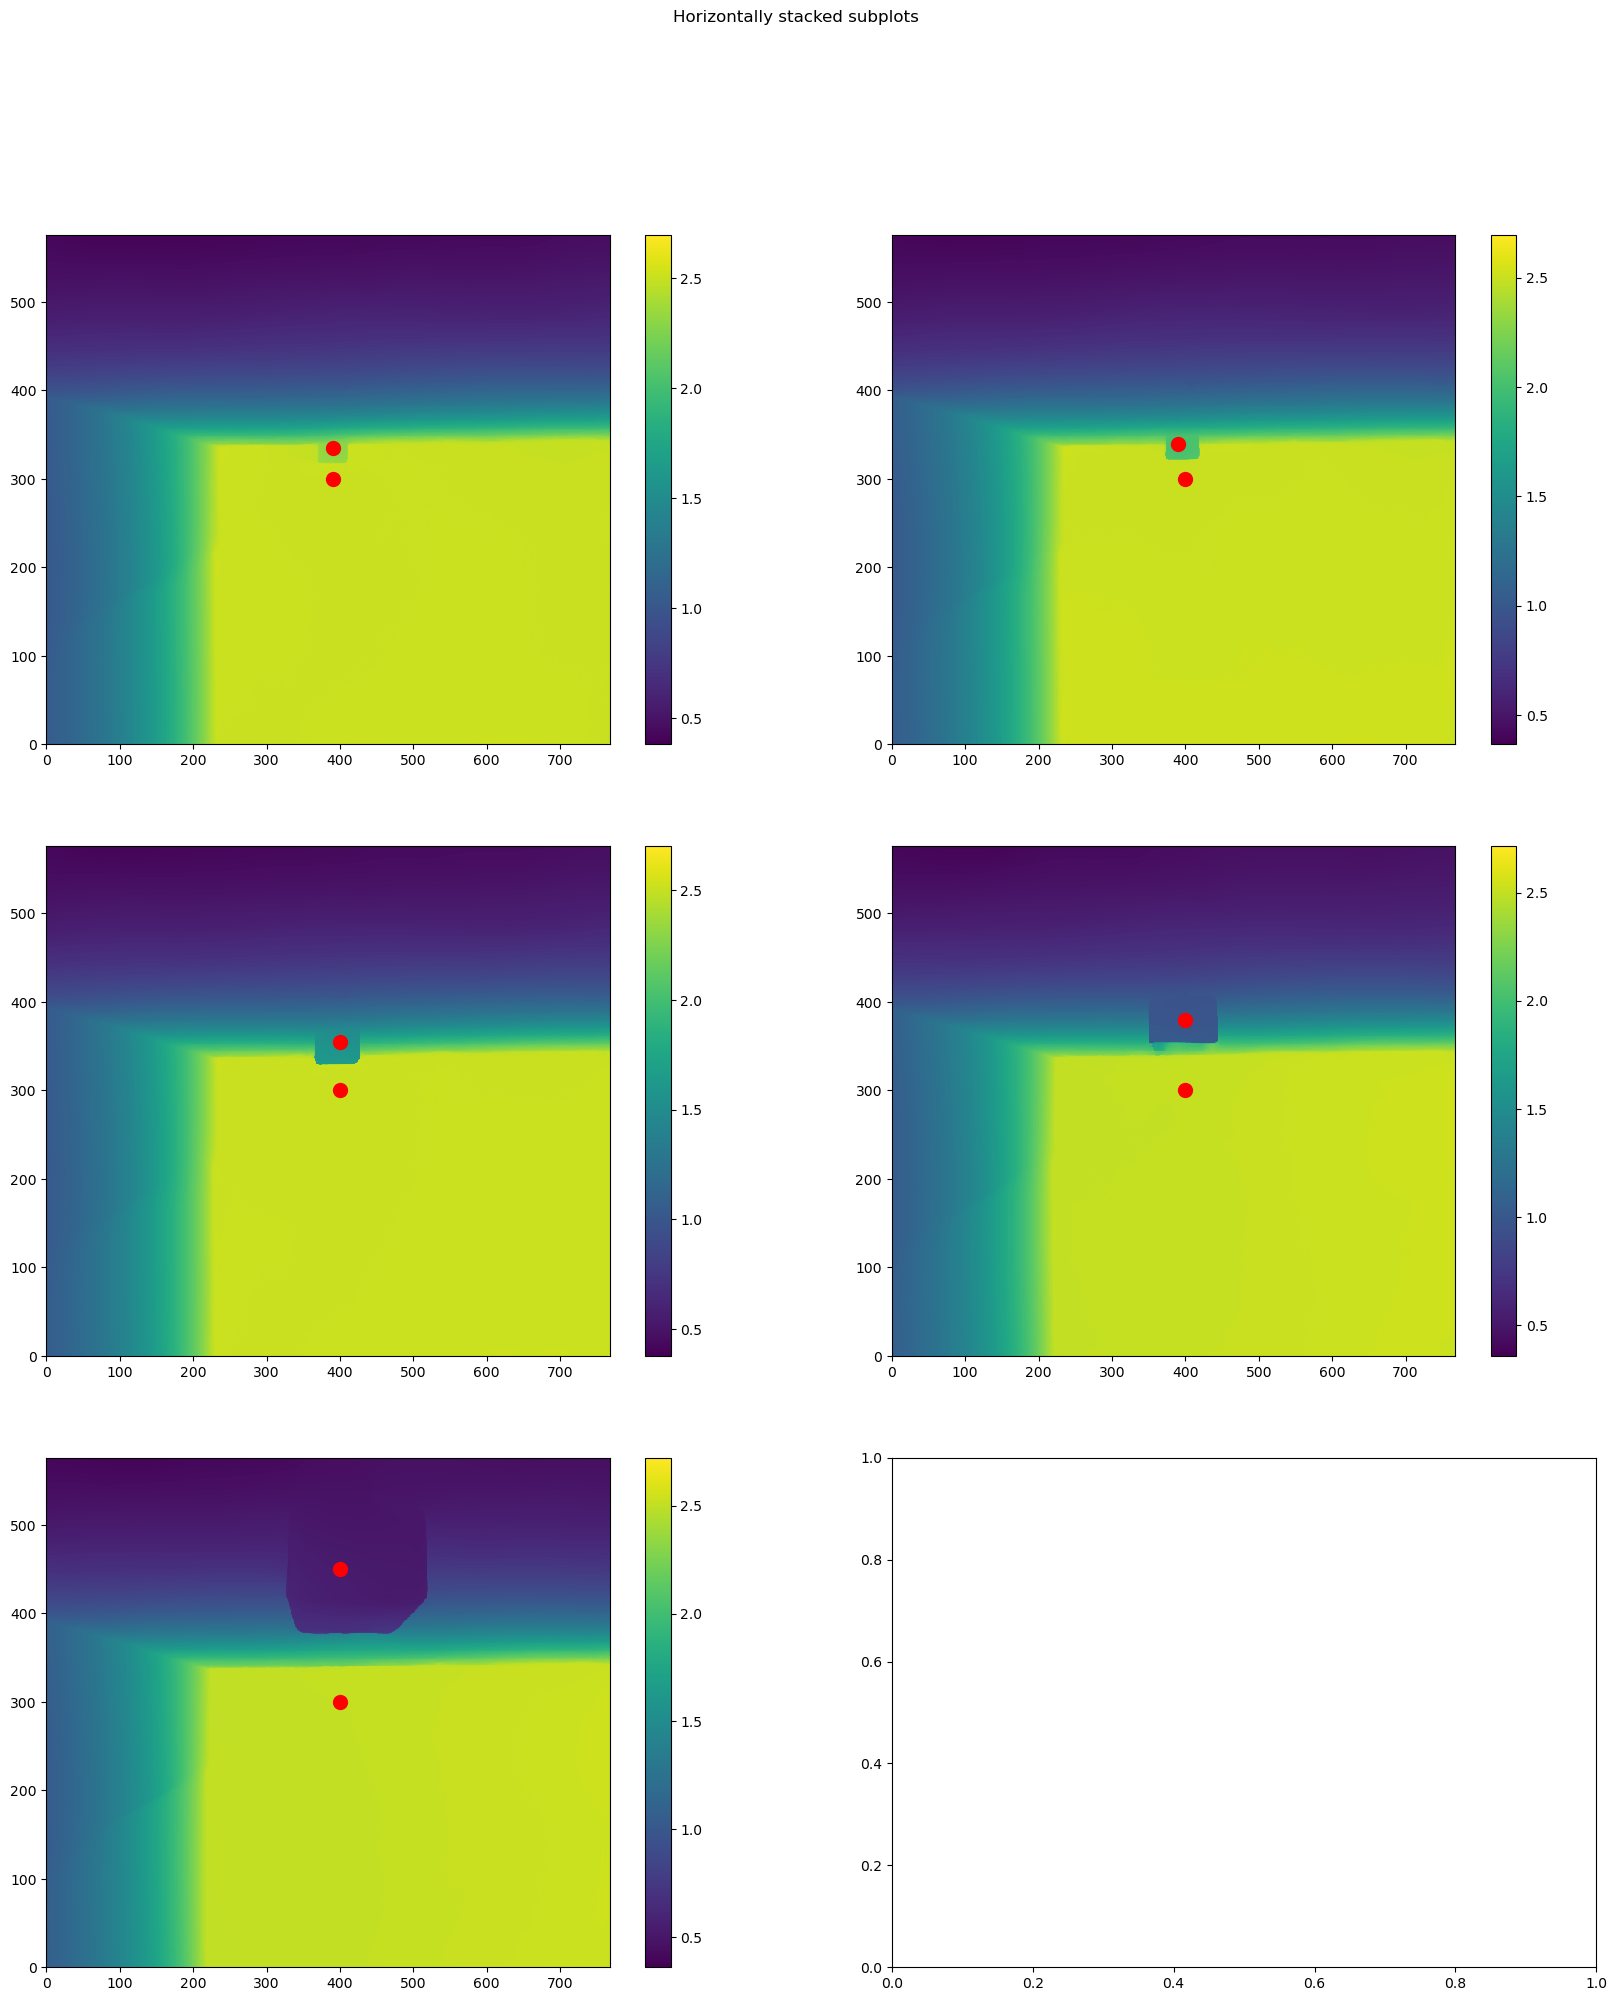

In [75]:
e2500.samples = Samples({
    '0': Sample(box=CoordSample(390, 335, 2.27), a4=CoordSample(390, 300, 2.5)),
    '1': Sample(box=CoordSample(390, 340, 2), a4=CoordSample(400, 300, 2.5)),
    '2': Sample(box=CoordSample(400, 355, 1.5), a4=CoordSample(400, 300, 2.5)),
    '3': Sample(box=CoordSample(400, 380, 1), a4=CoordSample(400, 300, 2.5)),
    '4': Sample(box=CoordSample(400, 450, 0.5), a4=CoordSample(400, 300, 2.5))
})

e2500.plot()